In [ ]:
## In this workbook we wanted to add more features with many columns of data that we will use PCA for 
## dimensionality reduction in order to see if we can get a model with better results.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import scipy.stats as stats
import numpy as np

import plotly.express as px
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [4]:
# Imported this dataframe that was created in our EDA notebook
flights_df = pd.read_csv("/Users/ckz/Desktop/DATA_SCIENCE_BOOTCAMP/Midterm-project/flights_df.csv")

# print the first few rows of the DataFrame
flights_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month,dep_hour,arr_hour,taxi_time,origin_state,flight_distance_category
0,2018-01-01,B6,B6,B6,880,B6,N794JB,880,12954,LGB,...,NaN,NaN,NaN,NaN,1,7,8,83.0,CA,SHORT
1,2018-01-01,B6,B6,B6,885,B6,N337JB,885,12478,JFK,...,NaN,NaN,NaN,NaN,1,7,9,120.0,NY,SHORT
2,2018-01-01,B6,B6,B6,886,B6,N337JB,886,14492,RDU,...,NaN,NaN,NaN,NaN,1,10,11,102.0,NC,SHORT
3,2018-01-01,B6,B6,B6,889,B6,N318JB,889,11278,DCA,...,NaN,NaN,NaN,NaN,1,18,19,162.0,DC,SHORT
4,2018-01-01,B6,B6,B6,891,B6,N348JB,891,10721,BOS,...,NaN,NaN,NaN,NaN,1,6,9,317.0,MA,MEDIUM


In [75]:
flights_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'mkt_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'month', 'dep_hour', 'arr_hour', 'taxi_time',
       'origin_state', 'flight_distance_category', 'avg_monthly_arr_delay',
       'avg_taxi_times_arr', 'traffic', 'holiday'],
      dtype='object')

In [6]:
flights_df['avg_monthly_arr_delay'] = flights_df.groupby('month')['arr_delay'].transform('mean')

In [7]:
# This feature creates the avg taxi times for the arrival hour 
flights_df['avg_taxi_times_arr'] = flights_df.groupby('arr_hour')['taxi_time'].transform('mean')

In [8]:
# Group the flights data by origin airport and count the number of flights for each airport
airport_counts = flights_df.groupby('origin')['flights'].transform('count')

# Determine the thresholds for each category based on the quartiles
thresholds = [0, airport_counts.quantile(0.25), airport_counts.quantile(0.5), airport_counts.quantile(0.75), np.inf]

# Define the categories
categories = ['Not Busy', 'Moderate', 'Busy', 'Very Busy']

# Assign the traffic category based on the number of flights from each airport
flights_df['traffic'] = pd.cut(airport_counts, bins=thresholds, labels=categories, right=False)

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar as holiday_calendar
from datetime import datetime

In [10]:
flights_df['fl_date'] = flights_df['fl_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

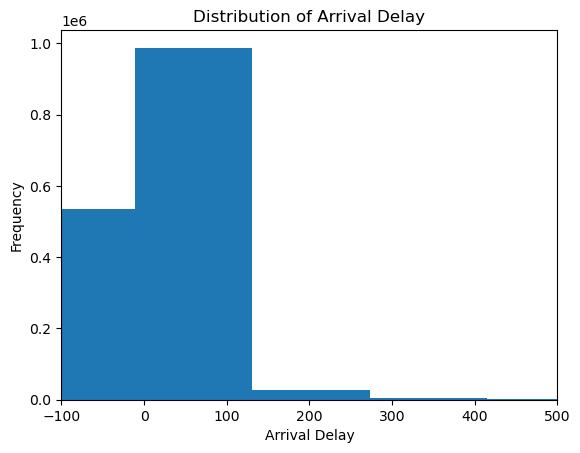

In [43]:
import matplotlib.pyplot as plt

# Plot histogram of 'arr_delay' with custom x-axis limits
plt.hist(flights_df['arr_delay'], bins=30)
plt.xlabel('Arrival Delay')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Delay')
plt.xlim(-100, 500)  # Set the x-axis limits
plt.show()

In [52]:
flights_df['avg_monthly_arr_delay'].value_counts()
                                        

9.369769     140155
9.147818     138068
2.939169     135062
10.231136    133095
2.848255     132802
6.487571     132791
5.256223     131089
2.631527     128856
1.728206     128645
4.198811     126311
3.517748     122942
7.158300     109229
Name: avg_monthly_arr_delay, dtype: int64

In [11]:
# holiday_cal
cal = holiday_calendar()
dr = flights_df['fl_date'] 
holidays = cal.holidays(start=dr.min(), end=dr.max())
flights_df['holiday'] = flights_df['fl_date'].dt.date.astype('datetime64').isin(holidays).astype(int)
flights_df.tail(5)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,month,dep_hour,arr_hour,taxi_time,origin_state,flight_distance_category,avg_monthly_arr_delay,avg_taxi_times_arr,traffic,holiday
1559040,2019-07-31,DL,DL,DL,2899,DL,N932AT,2899,10397,ATL,...,7,15,17,114.0,GA,SHORT,9.147818,177.955554,Very Busy,0
1559041,2019-07-31,DL,DL,DL,2899,DL,N932AT,2899,11057,CLT,...,7,17,18,83.0,NC,SHORT,9.147818,170.038468,Very Busy,0
1559042,2019-07-31,DL,DL,DL,2900,DL,N301DQ,2900,10397,ATL,...,7,12,14,175.0,GA,MEDIUM,9.147818,178.305499,Very Busy,0
1559043,2019-07-31,DL,DL,DL,2900,DL,N301DQ,2900,11624,EYW,...,7,15,17,126.0,FL,MEDIUM,9.147818,177.955554,Not Busy,0
1559044,2019-07-31,DL,DL,DL,2901,DL,N397DA,2901,11292,DEN,...,7,7,9,159.0,CO,SHORT,9.147818,146.300733,Very Busy,0


In [11]:
flights_df.to_csv('/Users/ckz/Desktop/DATA_SCIENCE_BOOTCAMP/Midterm-project/flights_df2.csv', index=False)

In [12]:
flights_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'month', 'dep_hour', 'arr_hour',
       'taxi_time', 'origin_state', 'flight_distance_category',
       'avg_monthly_arr_delay', 'avg_taxi_times_arr', 'traffic', 'holiday'],
      dtype='object')

In [53]:
flights_df = flights_df[['fl_date', 'mkt_unique_carrier', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
        'month', 'dep_hour', 'arr_hour',
       'taxi_time', 'origin_state', 'flight_distance_category',
       'avg_monthly_arr_delay', 'avg_taxi_times_arr', 'traffic', 'holiday']]


In [54]:
flights_df.isnull().sum()

fl_date                     0
mkt_unique_carrier          0
mkt_carrier                 0
mkt_carrier_fl_num          0
op_unique_carrier           0
tail_num                    0
op_carrier_fl_num           0
origin_airport_id           0
origin                      0
origin_city_name            0
dest_airport_id             0
dest                        0
dest_city_name              0
crs_dep_time                0
dep_time                    0
dep_delay                   0
taxi_out                    0
wheels_off                  0
wheels_on                   0
taxi_in                     0
crs_arr_time                0
arr_time                    0
arr_delay                   0
cancelled                   0
diverted                    0
dup                         0
crs_elapsed_time            0
actual_elapsed_time         0
air_time                    0
flights                     0
distance                    0
month                       0
dep_hour                    0
arr_hour  

In [76]:
# # Shuffle the data in the DataFrame and create a sample with half the size
sample_size = len(flights_df) // 10

flights_df_sample = flights_df.sample(n=sample_size, random_state=42)

## Reset the index of the shuffled sample

flights_df_sample.reset_index(drop=True, inplace=True)

In [77]:
flights_df_sample['tail_num'].unique()

array(['N213NN', 'N939AT', 'N85320', ..., 'N68061', 'N1602', 'N79011'],
      dtype=object)

In [78]:
flights_df_sample['tail_info'] = flights_df_sample['tail_num'].apply(lambda x: ''.join([char for char in str(x) if char.isalpha()]) + str(len(str(x.replace('-', '')))) if str(x).replace('-', '').isalnum() else '')



In [79]:
flights_df_sample['tail_info'].unique()

array(['NNN6', 'NAT6', 'N6', 'NCA6', 'NSY6', 'NWN6', 'ND6', 'NDQ6',
       'NDL6', 'NSW6', 'NH6', 'NB6', 'NQ6', 'NUW6', 'NNW6', 'NLR6',
       'NDN6', 'NJB6', 'NA6', 'NAA6', 'NVA6', 'NV5', 'NSA6', 'NJQ6',
       'NUA6', 'NUS6', 'NPP6', 'NAW6', 'NSK6', 'NAE6', 'NW6', 'NAK6',
       'NAN6', 'NPQ6', 'NNK6', 'NHQ6', 'NFR6', 'NFJ6', 'NCZ6', 'NJS6',
       'NML6', 'NAU6', 'NTW6', 'NXJ6', 'NNB6', 'NLV6', 'NKS6', 'NYX6',
       'NRW6', 'NAY6', 'NEA6', 'NQX6', 'NGJ6', 'NF6', 'NZW6', 'NPM6',
       'NNV6', 'NDA6', 'NHA6', 'NPS6', 'NBG6', 'NAS6', 'NEV6', 'NFF6',
       'NK6', 'NC6', 'NNS6', 'NUY6', 'NNG6', 'NPN6', 'NJE6', 'NJH6',
       'NP6', 'NJ6', 'NZ6', 'NM6', 'NBR6', 'NHK6', 'NT6', 'NEG6', 'NE6',
       'NX6', 'NDX6', 'NPB6', 'NR6', 'NJT6', 'N5', 'NJL6', 'NJW6', 'NV6',
       'NGB6', 'NDW6', 'NJ5', 'NPR6', 'NRP6', 'NDU6', 'NRJ6', 'NS6',
       'NU6', 'NAL6', 'NPD6', 'NAM6', 'NDE6', 'NMJ6', 'NBC6', 'NMD6',
       'NDZ6', 'NPH6', 'NRG6', 'NN6', 'NG6', 'NL6', 'NPC6', 'NCB6',
       'NMS6', 'NNX

In [80]:
unique_count = flights_df_sample['tail_info'].nunique()
print("Unique count of tail_info:", unique_count)

Unique count of tail_info: 195


In [81]:
flights_dfs = flights_df_sample.copy()

In [83]:
flights_df_sample = flights_df_sample[['fl_date','mkt_unique_carrier','tail_info',
        'taxi_out', 'taxi_in',
        'cancelled', 'diverted',
        'air_time', 'flights', 'distance',
        'month', 'dep_hour', 'arr_hour',
       'origin_state', 'flight_distance_category',
       'avg_monthly_arr_delay', 'avg_taxi_times_arr', 'traffic', 'holiday']]

In [84]:
numerical_columns = ['taxi_out','taxi_in','air_time','flights','distance','avg_taxi_times_arr']
                    
categorical_columns = ['mkt_unique_carrier','diverted','month','dep_hour','arr_hour','origin_state','flight_distance_category','traffic','holiday','tail_info']

In [85]:
df_encoded = pd.get_dummies(data=flights_df_sample, columns=['mkt_unique_carrier',
        'cancelled', 'diverted','tail_info',  
        'month', 'dep_hour', 'arr_hour',
        'origin_state', 'flight_distance_category',
        'traffic', 'holiday'], drop_first=False)


In [86]:
df_encoded.shape

(155904, 338)

In [87]:
df_encoded2 = pd.get_dummies(data=flights_df_sample, columns=['mkt_unique_carrier',
        'cancelled', 'diverted',  
        'month', 'dep_hour', 'arr_hour',
        'flight_distance_category',
        'traffic', 'holiday'], drop_first=False)

In [107]:
df_encoded2.columns

Index(['taxi_out', 'taxi_in', 'air_time', 'flights', 'distance',
       'origin_state', 'avg_monthly_arr_delay', 'avg_taxi_times_arr',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
       'mkt_unique_carrier_WN', 'cancelled_0.0', 'diverted_0.0', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dep_hour_0',
       'dep_hour_1', 'dep_hour_2', 'dep_hour_3', 'dep_hour_4', 'dep_hour_5',
       'dep_hour_6', 'dep_hour_7', 'dep_hour_8', 'dep_hour_9', 'dep_hour_10',
       'dep_hour_11', 'dep_hour_12', 'dep_hour_13', 'dep_hour_14',
       'dep_hour_15', 'dep_hour_16', 'dep_hour_17', 'dep_hour_18',
       'dep_hour_19', 'dep_hour_20', 'dep_hour_21', 'dep_hour_2

In [66]:
# Separate numeric columns and encoded columns

encoded_columns = df_encoded.drop(columns=numerical_columns)

In [67]:
# Scale the numeric columns
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_encoded[numerical_columns])

# Create a DataFrame for the scaled numeric data
df_scaled_numeric = pd.DataFrame(scaled_numeric_data, columns=numerical_columns)

# Rejoin the scaled numeric data with the encoded columns
df_scaled_encoded = pd.concat([df_scaled_numeric, encoded_columns], axis=1)

In [68]:
df_X = df_scaled_encoded.copy()

In [69]:
df_X = df_X.drop('fl_date', axis=1)

In [71]:
df_X['avg_monthly_arr_delay'].head()

0    10.231136
1    10.231136
2    10.231136
3     9.147818
4     9.369769
Name: avg_monthly_arr_delay, dtype: float64

Text(0, 0.5, '% Cumulative explained variance')

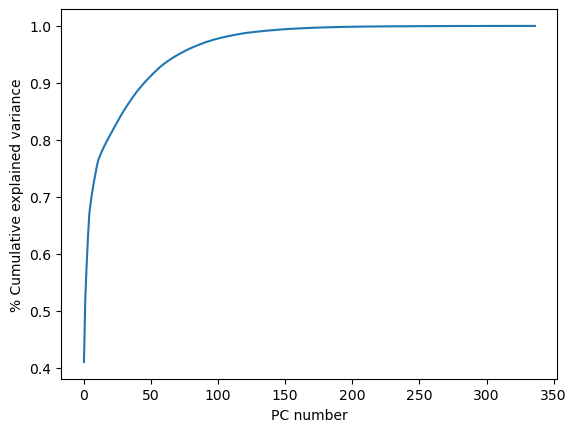

In [72]:
pca = PCA().set_output(transform="pandas")
pca.fit_transform(df_X) 

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')

In [73]:
pca = PCA(n_components=100).set_output(transform="pandas")
df_pca = pca.fit_transform(df_X) #enconded and scaled data (that was passed into clustering algo)
df_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca90,pca91,pca92,pca93,pca94,pca95,pca96,pca97,pca98,pca99
0,4.763724,0.405790,-0.342041,0.042173,0.225853,-0.648633,1.073258,-0.658706,-0.073182,-0.125935,...,-0.013361,0.073574,-0.085773,-0.066738,0.005374,0.071220,0.018348,0.029074,-0.049406,0.139973
1,4.751046,-1.458564,0.009708,0.193835,0.091624,0.502195,-0.161046,0.892987,0.318640,-0.844744,...,0.170852,-0.228383,-0.132866,-0.366680,-0.118286,0.003764,0.106912,0.050085,-0.036405,-0.021110
2,4.768462,1.342485,-0.702872,-0.254509,0.239651,-0.330620,0.061780,1.110903,-0.166568,0.720675,...,0.026801,0.000980,0.012936,0.026439,-0.044229,-0.077882,-0.009646,0.013864,-0.044308,-0.029747
3,3.660279,-1.693197,-0.223442,-0.321374,-0.042859,0.436954,-0.714894,-0.146619,0.576117,-0.553373,...,-0.068578,-0.086342,0.053453,0.210006,0.158966,-0.095036,-0.130819,-0.095437,0.260264,-0.181219
4,3.889391,-1.079058,-0.228598,-0.142672,-0.000873,0.624507,-0.112207,0.402767,0.007062,-0.485093,...,0.017099,-0.067045,0.054104,0.044633,-0.046992,0.099993,-0.169654,-0.155144,-0.091975,-0.065199


Coefficients: [  0.99916657  -0.09980227   0.83569072  -0.44085648   1.11074943
  -0.68712443   2.05615758   0.89656816  -0.49144551   3.43640666
  -1.14752106  -1.51659989 -12.79095423  -2.84272577  -1.3397959
  -2.93318129   1.7101028    4.49925928   1.81440748   0.3243027
  -0.8610073    0.53444237   1.31085915  -0.39176582  -2.05421214
  -0.31830505  -0.58700305   0.11348696   0.99641094   0.16176917
  -0.74197889   1.43747575   2.77104184  -1.3270951   -1.26178853
  -0.35760019  -1.32144924  -1.78604979   0.65542619   0.47731015
  -1.56974585   1.07310524  -1.59133726   2.2713863    0.37316747
   0.55158048  -0.57106735   1.05949466   1.32456634   1.37255657
   0.64664553  -1.17052685   0.34992392  -1.9572044   -0.51355129
  -1.26700129   1.70024776   0.82789629  -1.42486902  -0.12940428
   3.37656696  -5.3670332   -2.10933315   0.46585733  10.12721222
  -2.10020326   0.49803018   3.6130811    1.31024302   2.38843536
  -1.97749848   4.04284975   2.86234966   1.44045947   0.039731


In [88]:
df_encoded2.columns

Index(['fl_date', 'tail_info', 'taxi_out', 'taxi_in', 'air_time', 'flights',
       'distance', 'origin_state', 'avg_monthly_arr_delay',
       'avg_taxi_times_arr', 'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
       'mkt_unique_carrier_WN', 'cancelled_0.0', 'diverted_0.0', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dep_hour_0',
       'dep_hour_1', 'dep_hour_2', 'dep_hour_3', 'dep_hour_4', 'dep_hour_5',
       'dep_hour_6', 'dep_hour_7', 'dep_hour_8', 'dep_hour_9', 'dep_hour_10',
       'dep_hour_11', 'dep_hour_12', 'dep_hour_13', 'dep_hour_14',
       'dep_hour_15', 'dep_hour_16', 'dep_hour_17', 'dep_hour_18',
       'dep_hour_19', 'dep_hour_20', 'd

In [90]:
df_encoded2 = df_encoded2.drop(['fl_date', 'tail_info'], axis=1)

In [106]:

# Linear regression model for PCA data

# Separate the input features (X) and the target variable (y)
X = df_encoded2[['taxi_out', 'taxi_in', 'flights','air_time',
       'distance','avg_monthly_arr_delay',
       'avg_taxi_times_arr', 'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
        'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
       'mkt_unique_carrier_WN','cancelled_0.0', 'diverted_0.0',
       'dep_hour_0',
       'dep_hour_1', 'dep_hour_2', 'dep_hour_3', 'dep_hour_4', 'dep_hour_5',
       'dep_hour_6', 'dep_hour_7', 'dep_hour_8', 'dep_hour_9', 'dep_hour_10',
       'dep_hour_11', 'dep_hour_12', 'dep_hour_13', 'dep_hour_14',
       'dep_hour_15', 'dep_hour_16', 'dep_hour_17', 'dep_hour_18',
       'dep_hour_19', 'dep_hour_20', 'dep_hour_21', 'dep_hour_22',
       'dep_hour_23', 'arr_hour_0', 'arr_hour_1', 'arr_hour_2', 'arr_hour_3',
       'arr_hour_4', 'arr_hour_5', 'arr_hour_6', 'arr_hour_7', 'arr_hour_8',
       'arr_hour_9', 'arr_hour_10', 'arr_hour_11', 'arr_hour_12',
       'arr_hour_13', 'arr_hour_14', 'arr_hour_15', 'arr_hour_16',
       'arr_hour_17', 'arr_hour_18', 'arr_hour_19', 'arr_hour_20',
       'arr_hour_21', 'arr_hour_22', 'arr_hour_23',
       'flight_distance_category_LONG', 
       'traffic_Very Busy',
       'holiday_1']]

y = flights_dfs['arr_delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)

# Print the coefficient and intercept of the linear regression model
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('R^2 Score:', score)

Coefficients: [-3.98013366e-03 -7.46015539e-03 -3.06096275e-10  4.49543715e-01
 -5.48258842e-02  1.05264412e+00 -2.63366071e-03 -1.38983720e+00
 -7.35219816e+00  3.26969133e+00 -3.84460202e+00  5.27243761e+00
  3.76059997e+00 -3.11840314e+00 -7.05923674e-01  1.80232852e+00
  5.14020729e+00 -2.83430052e+00  5.55111512e-14  8.52651283e-14
  1.77953667e+00 -3.91811966e+00  3.46266774e+00 -1.08594365e+01
 -6.46014287e+00 -4.75400464e+00 -1.50464116e+00 -6.28881506e-01
  2.09728848e+00  2.25537675e+00  3.35733820e+00  2.66802870e+00
  3.00045244e+00  2.75201962e+00  1.21929856e+00  1.03264597e-01
  2.30453141e-01  9.36087738e-01  2.19485726e-01 -8.39165140e-01
  6.24857234e-01 -2.14407926e+00 -1.60077843e+00  8.00309358e+00
  2.29128562e+00  4.78584315e+00 -6.94484840e+00 -2.02778247e+01
  3.75204324e+00  2.21570351e+00  4.41610599e-01 -3.38040562e+00
 -3.90807719e+00 -4.53203838e+00 -6.37445755e+00 -5.70070330e+00
 -5.63440410e+00 -4.12356889e+00 -2.56902239e+00  3.97459387e-01
  2.5846607

In [ ]:
# This PCA model is slightly better then the PCA model in the models notebook however nothing significant.